In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import model_selection
from scipy import stats

#Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [4]:
d_parser = lambda x: pd.to_datetime(x)
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], date_parser=d_parser)
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
df.shape

(144, 2)

In [6]:
df.set_index('Month', inplace = True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Shifted Correlation Test

In [7]:
class SCT:
    """
    Shifted correlation test / See the correlation between shifted values
    """
    def get_shifted_correlation(self, df, lag):
        """
        Find the corr for a single lag value
        """
        #Create a dataframe to add correlation columns
        corr = pd.DataFrame()
        #Loop through the dataframe 
        for column in df:
            name = column+'_s'
            dt = df.copy()
            #Shift selected column
            dt[name] = dt[column].shift(lag)
            #Get the corr for shifted column and add it to the corr dataframe
            data = dt.corr(method='spearman')[name]
            corr = pd.concat([corr, data], axis=1)
            corr.rename(columns = {name : column}, inplace = True)
        corr = corr[:df.shape[1]]
        corr = corr.transpose()
        corr['Lag'] = lag
        return corr
    
    def get_shifted_correlation_range(self, df, lags, lagf):
        """
        Find corr in range of lag values
        """
        corr = pd.DataFrame()
        lag_vals=[]
        #Loop in range of lag values
        for i in range((lagf-lags)+1):
            lag = lags+i
            #Loop through columns for each lag value
            for column in df:
                name = column+'_s'
                dt = df.copy()
                dt[name] = dt[column].shift(lag)
                data = dt.corr(method='spearman')[name]
                corr = pd.concat([corr, data], axis=1)
                lag_vals.append(lag)
                #corr.rename(columns = {name : column}, inplace = True)
        corr = corr[:df.shape[1]]
        corr = corr.transpose()
        corr['Lag'] =lag_vals
        return corr

    def get_shifted_correlation_period(self, data, lags, lagf, period, days):
        """
        Find corr in range of lag values with the desired period
        """
        corr = pd.DataFrame()
        start_day = 0
        #Loop through the periods
        for month in range(1, period+1):

            #Get the desired interval 
            df = data.iloc[start_day:month*days]
            start_day += days
            dt = scl(df,lags,lagf)

            beginning_date = df.index[:][0].date()
            end_date = df.index[:][-1].date()

            dt['Beginning Date'] = beginning_date
            dt['End Date'] = end_date

            corr = pd.concat([corr, dt])
        return corr
    
    def get_correlation_stats(self, data, threshold, percentage, lag_val):
        """
        Label the corr values 
        """
        
        crv = []
        l = data[data['Lag']==lag_val].sort_index()
        index = l.index.unique()
        for i in range(len(l.index.unique())):
            for column in l.columns[:len(l.index.unique())]:
                #Get the rows with same index
                temp = l[l.index == index[i]]
                temp_pos = temp[column] > threshold
                temp_neg = temp[column] < -threshold
                if True in temp_pos.unique():
                    pos_per = temp_pos.value_counts()[True]/len(temp_pos) * 100
                    if pos_per > percentage:
                        crv.append([index[i], column, 1, 'positive', lag_val])
                    else:
                        crv.append([index[i], column, 0, 'positive', lag_val])
                if True in temp_neg.unique():
                    neg_per = temp_neg.value_counts()[True]/len(temp_pos) * 100
                    if neg_per > percentage:
                        crv.append([index[i], column, 1, 'negative', lag_val])
                    else:
                        crv.append([index[i], column, 0, 'negative', lag_val])
        dataframe = pd.DataFrame(crv, columns=['Asset_Shifted','Asset','High_Corr','Corr_Kind','Lag'])
        return dataframe

# Check Stationarity

In [8]:
def check_stationarity(df):
    adf = adfuller(df['#Passengers'], autolag='AIC')
    print('#Passengers:')
    print(f'ADF Statistic: {adf[0]}')
    print(f'p-vaue: {adf[1]}')

    if adf[1] < 0.05:
        print('Stationary')

    else: 
        print('Not Stationary')

In [9]:
check_stationarity(df)

#Passengers:
ADF Statistic: 0.8153688792060411
p-vaue: 0.9918802434376409
Not Stationary


# Train Test Split

In [10]:
train, test = model_selection.train_test_split(df, test_size=12)

# Seasonal Decompose 

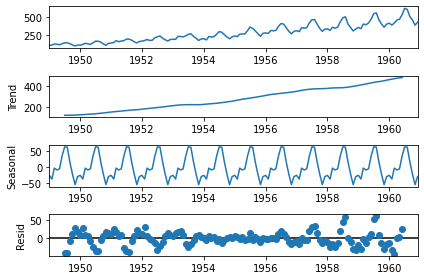

In [11]:
sd = seasonal_decompose(df,model='additive')
fig = sd.plot()

# SARIMA model

In [12]:
SARIMA_model = pm.auto_arima(df['#Passengers'], test='adf', trace=True, stepwise=True, m=12, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.11 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.42 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.16 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.38 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.15 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.30 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.34 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=0.79 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.07 sec
 ARIMA(3,1,1)(0,1,0

In [13]:
print(SARIMA_model.aic())

1017.8467852169199


In [14]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Thu, 25 Aug 2022   AIC                           1017.847
Time:                                     13:42:23   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.987      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.344      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.602      0.000      -1.057      -0.907
sigma2       129.3041     14.554      8.884      0.000     100.778     157.830
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
SARIMA_model_fit = SARIMA_model.fit(train)

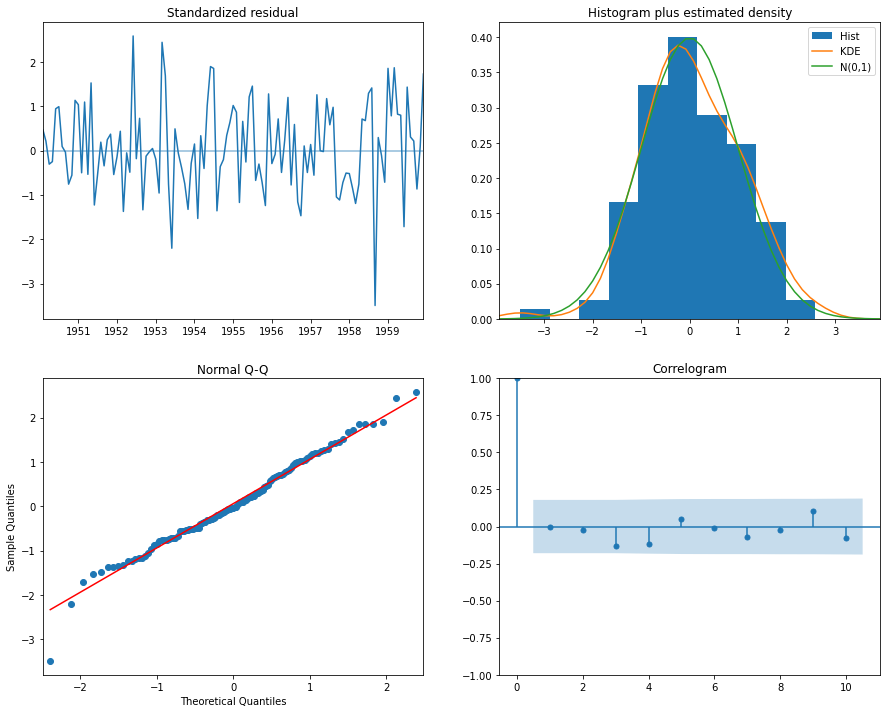

In [16]:
SARIMA_model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [17]:
test_preds = SARIMA_model_fit.predict(n_periods=test.shape[0])
print(test_preds)

1960-01-01    425.135227
1960-02-01    408.815629
1960-03-01    471.901546
1960-04-01    462.400117
1960-05-01    486.128207
1960-06-01    538.276502
1960-07-01    614.195625
1960-08-01    625.239734
1960-09-01    529.215677
1960-10-01    473.228797
1960-11-01    428.221642
1960-12-01    471.225544
Freq: MS, dtype: float64


In [18]:
test_preds_df = pd.DataFrame(test_preds, index=test.index, columns=['Predictions'])

<AxesSubplot:xlabel='Month'>

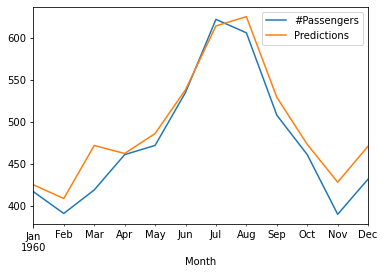

In [19]:
pd.concat([test, test_preds_df], axis=1).plot()

<AxesSubplot:xlabel='Month'>

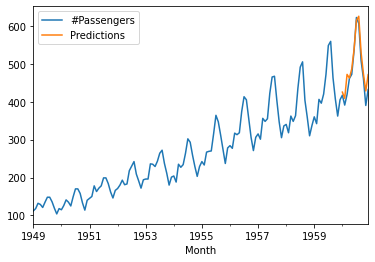

In [20]:
pd.concat([df,test_preds_df],axis=1).plot()

In [21]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, test_preds)))

Test RMSE: 24.874


In [22]:
ap_df = pd.concat([df[train.shape[0]:], test_preds_df], axis=1)
ap_df

,#Passengers,Predictions
Month,,
1960-01-01,417,425.135227
1960-02-01,391,408.815629
1960-03-01,419,471.901546
1960-04-01,461,462.400117
1960-05-01,472,486.128207
1960-06-01,535,538.276502
1960-07-01,622,614.195625
1960-08-01,606,625.239734
1960-09-01,508,529.215677


In [23]:
def percentage_error(df):
    errors = []
    for index, row in df.iterrows():
        error = (abs(row[df.columns[0]] - row[df.columns[1]]) / row[df.columns[0]]) * 100
        errors.append(error)
    errors_df = pd.DataFrame(errors,columns=['Error(%)'], index=df.index)
    return pd.concat([df, errors_df], axis=1)

In [24]:
P_error = percentage_error(ap_df)
P_error

,#Passengers,Predictions,Error(%)
Month,,,
1960-01-01,417,425.135227,1.950894
1960-02-01,391,408.815629,4.556427
1960-03-01,419,471.901546,12.625667
1960-04-01,461,462.400117,0.303713
1960-05-01,472,486.128207,2.993264
1960-06-01,535,538.276502,0.612430
1960-07-01,622,614.195625,1.254723
1960-08-01,606,625.239734,3.174874
1960-09-01,508,529.215677,4.176314


In [25]:
slope, intercept, r, p, std_err = stats.linregress(P_error['#Passengers'], P_error['Predictions'])

In [26]:
def regline(data):
    return slope * data + intercept

In [27]:
linmodel = list(map(regline, P_error['#Passengers']))

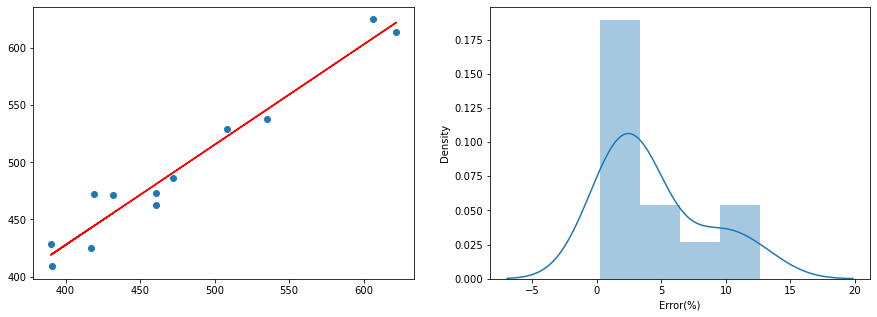

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(P_error['#Passengers'], P_error['Predictions'])
plt.plot(P_error['#Passengers'], linmodel, color='red')

plt.subplot(1,2,2)
sns.distplot(P_error['Error(%)']);

In [29]:
def error_values(df):
    
    mepe = round(df['Error(%)'].mean(), 3)
    mpe = round(df['Error(%)'].mean(), 3)
    
    meae = round(median_absolute_error(df['#Passengers'], df['Predictions']), 3)
    mae = round(mean_absolute_error(df['#Passengers'], df['Predictions']), 3)
    mse = round(mean_squared_error(df['#Passengers'], df['Predictions']), 3)
    rmse = round(np.sqrt(mse), 3)
    
    std = round(df['#Passengers'].std(), 3)
    
    errors = [mepe, mpe, meae, mae, mse, rmse, std]
    return errors

In [30]:
error_values(P_error)

[4.432, 4.432, 15.972, 19.633, 618.726, 24.874, 77.737]